<a href="https://colab.research.google.com/github/ylkim1947/Car_color_classfication/blob/main/Car_color_classification(EfficientNet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

In [18]:
# Required constants.
TRAIN_DIR = '/content/drive/MyDrive/cp2/codestates_cp2_cars/094/1.Training/'
VALID_DIR = '/content/drive/MyDrive/cp2/codestates_cp2_cars/094/2.Validation/'
IMAGE_SIZE = 480 # Image size of resize when applying transforms.
BATCH_SIZE = 32
NUM_WORKERS = 4 # Number of parallel processes for data preparation.
# computation device
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Computation device: cuda



# 01. Dataset 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# %cd /content/drive/MyDrive/cp2/codestates_cp2_cars/094/1.Training

# #!unzip -qq "/content/drive/MyDrive/cp2/codestates_cp2_cars/094/1.Training/검정.zip" -d  "/content/drive/MyDrive/cp2/codestates_cp2_cars/094/1.Training/black"
# #!unzip  "/content/drive/MyDrive/cp2/codestates_cp2_cars/094/1.Training/회색.zip" -d  "/content/drive/MyDrive/cp2/codestates_cp2_cars/094/1.Training/grey" 
# #!unzip  "/content/drive/MyDrive/cp2/codestates_cp2_cars/094/1.Training/빨강.zip" -d  "/content/drive/MyDrive/cp2/codestates_cp2_cars/094/1.Training/red"
# #!unzip  "/content/drive/MyDrive/cp2/codestates_cp2_cars/094/1.Training/흰색.zip" -d  "/content/drive/MyDrive/cp2/codestates_cp2_cars/094/1.Training/white"
# !unzip  "/content/drive/MyDrive/cp2/codestates_cp2_cars/094/1.Training/파랑.zip" -d  "/content/drive/MyDrive/cp2/codestates_cp2_cars/094/1.Training/blue"

In [5]:
# Training transforms
def get_train_transform(IMAGE_SIZE):
    train_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(35),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        #transforms.RandomGrayscale(p=0.5),
        transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
        transforms.RandomPosterize(bits=2, p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
    ])
    return train_transform

# Validation transforms
def get_valid_transform(IMAGE_SIZE):
    valid_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
    ])
    return valid_transform

In [6]:

def get_datasets():
    """
    Function to prepare the Datasets.
    Returns the training and validation datasets along 
    with the class names.
    """
    dataset_train = datasets.ImageFolder(
        TRAIN_DIR, 
        transform=(get_train_transform(IMAGE_SIZE))
    )
    dataset_valid = datasets.ImageFolder(
        VALID_DIR, 
        transform=(get_valid_transform(IMAGE_SIZE))
    )
    return dataset_train, dataset_valid, dataset_train.classes

def get_data_loaders(dataset_train, dataset_valid):
    """
    Prepares the training and validation data loaders.
    :param dataset_train: The training dataset.
    :param dataset_valid: The validation dataset.
    Returns the training and validation data loaders.
    """
    train_loader = DataLoader(
        dataset_train, batch_size=BATCH_SIZE, 
        shuffle=True, num_workers=NUM_WORKERS
    )
    valid_loader = DataLoader(
        dataset_valid, batch_size=BATCH_SIZE, 
        shuffle=False, num_workers=NUM_WORKERS
    )
    return train_loader, valid_loader 

# 02. Model : EfficientNet

In [19]:
import torch.nn as nn
from torchvision import models

def build_model(pretrained=True, fine_tune=True, num_classes=5):
    if pretrained:
        print('[INFO]: Loading pre-trained weights')
    else:
        print('[INFO]: Not loading pre-trained weights')
    #model = models.efficientnet_b1(pretrained=pretrained)
    model = models.efficientnet_v2_m(pretrained=pretrained)

    if fine_tune:
        print('[INFO]: Fine-tuning all layers...')
        for params in model.parameters():
            params.requires_grad = True
    elif not fine_tune:
        print('[INFO]: Freezing hidden layers...')
        for params in model.parameters():
            params.requires_grad = False

    # Change the final classification head.
    model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)
    return model

# 03. Training Setting

In [20]:
import torch
import argparse
import torch.nn as nn
import torch.optim as optim
import time

from tqdm.auto import tqdm

#from model import build_model
#from datasets import get_datasets, get_data_loaders

In [21]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [22]:

# Training function.
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation.
        loss.backward()
        # Update the weights.
        optimizer.step()
    
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc


In [23]:
# Validation function.
def validate(model, testloader, criterion, class_names):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc


# 04. Save model setting

In [12]:
import torch
import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')

In [13]:

def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, f"/content/drive/MyDrive/cp2/codestates_cp2_cars/094/outputs/model.pth")

def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # Accuracy plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f"/content/drive/MyDrive/cp2/codestates_cp2_cars/094/outputs/accuracy.png")
    
    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f"/content/drive/MyDrive/cp2/codestates_cp2_cars/094/outputs/loss.png")




plt.style.use('ggplot')
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, '/content/drive/MyDrive/cp2/codestates_cp2_cars/094/outputs/best_model.pth')

# 05. Run training section

In [14]:
# Load the training and validation datasets.
dataset_train, dataset_valid, dataset_classes = get_datasets()
print(f"[INFO]: Number of training images: {len(dataset_train)}")
print(f"[INFO]: Number of validation images: {len(dataset_valid)}")
# Load the training and validation data loaders.
train_loader, valid_loader = get_data_loaders(dataset_train, dataset_valid)

[INFO]: Number of training images: 36293
[INFO]: Number of validation images: 6815


In [15]:
dataset_classes

['black', 'blue', 'grey', 'red', 'white']

In [16]:
torch.cuda.is_available()

True

Computation device: cuda
Learning rate: 0.002
Epochs to train for: 20

[INFO]: Loading pre-trained weights
[INFO]: Fine-tuning all layers...
52,864,761 total parameters.
52,864,761 training parameters.
[INFO]: Epoch 1 of 20
Training


  0%|          | 0/2269 [00:00<?, ?it/s]

Validation


  0%|          | 0/426 [00:00<?, ?it/s]

Training loss: 0.738, training acc: 69.785
Validation loss: 1.214, validation acc: 60.866

Best validation loss: 1.2137907114554192

Saving best model for epoch: 1

--------------------------------------------------
[INFO]: Epoch 2 of 20
Training


  0%|          | 0/2269 [00:00<?, ?it/s]

Validation


  0%|          | 0/426 [00:00<?, ?it/s]

Training loss: 0.608, training acc: 75.640
Validation loss: 1.244, validation acc: 61.981
--------------------------------------------------
[INFO]: Epoch 3 of 20
Training


  0%|          | 0/2269 [00:00<?, ?it/s]

Validation


  0%|          | 0/426 [00:00<?, ?it/s]

Training loss: 0.559, training acc: 77.467
Validation loss: 1.087, validation acc: 61.908

Best validation loss: 1.0868292010113498

Saving best model for epoch: 3

--------------------------------------------------
[INFO]: Epoch 4 of 20
Training


  0%|          | 0/2269 [00:00<?, ?it/s]

Validation


  0%|          | 0/426 [00:00<?, ?it/s]

Training loss: 0.515, training acc: 79.591
Validation loss: 1.146, validation acc: 64.417
--------------------------------------------------
[INFO]: Epoch 5 of 20
Training


  0%|          | 0/2269 [00:00<?, ?it/s]

Validation


  0%|          | 0/426 [00:00<?, ?it/s]

Training loss: 0.486, training acc: 80.655
Validation loss: 1.090, validation acc: 66.310
--------------------------------------------------
[INFO]: Epoch 6 of 20
Training


  0%|          | 0/2269 [00:00<?, ?it/s]

Validation


  0%|          | 0/426 [00:00<?, ?it/s]

Training loss: 0.449, training acc: 82.220
Validation loss: 1.089, validation acc: 66.295
--------------------------------------------------
[INFO]: Epoch 7 of 20
Training


  0%|          | 0/2269 [00:00<?, ?it/s]

Validation


  0%|          | 0/426 [00:00<?, ?it/s]

Training loss: 0.425, training acc: 83.126
Validation loss: 1.072, validation acc: 65.869

Best validation loss: 1.0717037297998728

Saving best model for epoch: 7

--------------------------------------------------
[INFO]: Epoch 8 of 20
Training


  0%|          | 0/2269 [00:00<?, ?it/s]

Validation


  0%|          | 0/426 [00:00<?, ?it/s]

Training loss: 0.412, training acc: 83.788
Validation loss: 1.182, validation acc: 66.926
--------------------------------------------------
[INFO]: Epoch 9 of 20
Training


  0%|          | 0/2269 [00:00<?, ?it/s]

Validation


  0%|          | 0/426 [00:00<?, ?it/s]

Training loss: 0.395, training acc: 84.421
Validation loss: 1.139, validation acc: 68.657
--------------------------------------------------
[INFO]: Epoch 10 of 20
Training


  0%|          | 0/2269 [00:00<?, ?it/s]

Validation


  0%|          | 0/426 [00:00<?, ?it/s]

Training loss: 0.380, training acc: 84.964
Validation loss: 1.282, validation acc: 67.454
--------------------------------------------------
[INFO]: Epoch 11 of 20
Training


  0%|          | 0/2269 [00:00<?, ?it/s]

Validation


  0%|          | 0/426 [00:00<?, ?it/s]

Training loss: 0.365, training acc: 85.435
Validation loss: 1.157, validation acc: 67.689
--------------------------------------------------
[INFO]: Epoch 12 of 20
Training


  0%|          | 0/2269 [00:00<?, ?it/s]

Validation


  0%|          | 0/426 [00:00<?, ?it/s]

Training loss: 0.352, training acc: 86.135
Validation loss: 1.117, validation acc: 69.802
--------------------------------------------------
[INFO]: Epoch 13 of 20
Training


  0%|          | 0/2269 [00:00<?, ?it/s]

Validation


  0%|          | 0/426 [00:00<?, ?it/s]

Training loss: 0.343, training acc: 86.606
Validation loss: 1.091, validation acc: 71.255
--------------------------------------------------
[INFO]: Epoch 14 of 20
Training


  0%|          | 0/2269 [00:00<?, ?it/s]

Validation


  0%|          | 0/426 [00:00<?, ?it/s]

Training loss: 0.334, training acc: 87.014
Validation loss: 1.117, validation acc: 71.299
--------------------------------------------------
[INFO]: Epoch 15 of 20
Training


  0%|          | 0/2269 [00:00<?, ?it/s]

Validation


  0%|          | 0/426 [00:00<?, ?it/s]

Training loss: 0.329, training acc: 87.135
Validation loss: 1.207, validation acc: 72.150
--------------------------------------------------
[INFO]: Epoch 16 of 20
Training


  0%|          | 0/2269 [00:00<?, ?it/s]

Validation


  0%|          | 0/426 [00:00<?, ?it/s]

Training loss: 0.317, training acc: 87.606
Validation loss: 1.245, validation acc: 70.858
--------------------------------------------------
[INFO]: Epoch 17 of 20
Training


  0%|          | 0/2269 [00:00<?, ?it/s]

Validation


  0%|          | 0/426 [00:00<?, ?it/s]

Training loss: 0.309, training acc: 87.799
Validation loss: 0.959, validation acc: 73.529

Best validation loss: 0.9587169788802744

Saving best model for epoch: 17

--------------------------------------------------
[INFO]: Epoch 18 of 20
Training


  0%|          | 0/2269 [00:00<?, ?it/s]

Validation


  0%|          | 0/426 [00:00<?, ?it/s]

Training loss: 0.301, training acc: 88.248
Validation loss: 1.087, validation acc: 72.238
--------------------------------------------------
[INFO]: Epoch 19 of 20
Training


  0%|          | 0/2269 [00:00<?, ?it/s]

Validation


  0%|          | 0/426 [00:00<?, ?it/s]

Training loss: 0.295, training acc: 88.521
Validation loss: 1.580, validation acc: 68.789
--------------------------------------------------
[INFO]: Epoch 20 of 20
Training


  0%|          | 0/2269 [00:00<?, ?it/s]

Validation


  0%|          | 0/426 [00:00<?, ?it/s]

Training loss: 0.291, training acc: 88.684
Validation loss: 1.162, validation acc: 72.370
--------------------------------------------------
TRAINING COMPLETE


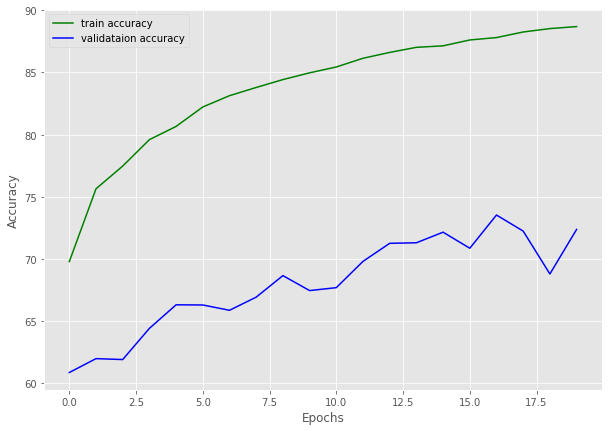

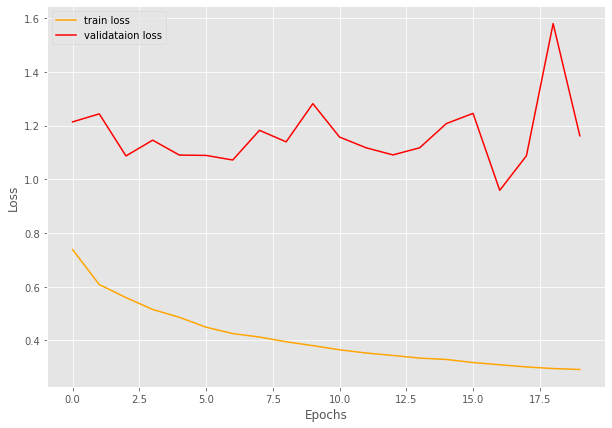

In [24]:
# Learning_parameters. 
lr = 0.002# args['learning_rate']
epochs = 20 #args['epochs']
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")
print(f"Learning rate: {lr}")
print(f"Epochs to train for: {epochs}\n")

# Load the model.
model = build_model(
    pretrained=True,
    fine_tune=True, 
    num_classes=len(dataset_classes)
).to(device)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

# Optimizer.
optimizer = optim.Adam(model.parameters(), lr=lr)
# Loss function.
criterion = nn.CrossEntropyLoss()

# initialize SaveBestModel class
save_best_model = SaveBestModel()

# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                            optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,  
                                                criterion, dataset_classes)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    # save the best model till now if we have the least loss in the current epoch
    save_best_model(
          valid_epoch_loss, epoch, model, optimizer, criterion
          )

    print('-'*50)
    time.sleep(2)


# Save the trained model weights.
save_model(epochs, model, optimizer, criterion)
# Save the loss and accuracy plots.
save_plots(train_acc, valid_acc, train_loss, valid_loss)
print('TRAINING COMPLETE')

